# Modelos de Clasificación

------------------------------------------------------


### Data Science and Machine Learning

#### Febrero 2023

**Aurora Cobo Aguilera**

**The Valley**

------------------------------------------------------

# 1. Otros algoritmos de clasificación

---
Ya hemos visto con detalle la regresión logística y el KNN. A continuación, vamos a mostrar por encima otros algoritmos de clasificación.


- Árboles de decisión
- Random Forests
- Clasificador lineal de Fisher



Para compararlos, utilizaremos un dataset artificial, que genera muestras de una mezcla de distribuciones Gaussianas.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

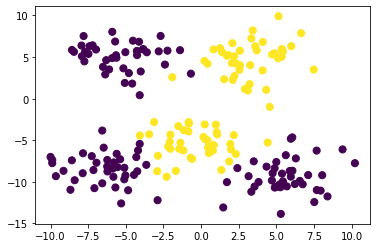

In [3]:
XX, YY = make_blobs(n_samples=200, centers=5, random_state=10, cluster_std=2)
YY[YY==4] = -1
YY[YY==3] = -1
YY[YY==2] = 1
YY[YY==0] = -1
plt.figure()
_=plt.scatter(XX[:, 0], XX[:, 1], c=YY, s=50, cmap='viridis')

xmin = np.min(XX[:, 0])
xmax = np.max(XX[:, 0])
ymin = np.min(XX[:, 1])
ymax = np.max(XX[:, 1])

Xg = np.linspace(xmin-.05*np.absolute(xmin), xmax + .05*np.absolute(xmax), 20) # o los valores que sea para x

Yg = np.linspace(ymin-.05*np.absolute(ymin), ymax + .05*np.absolute(ymax), 20)   # o los valores que sea para y
X, Y = np.meshgrid(Xg, Yg)
Xshape = X.shape

x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))

## 1.1. Árboles de decisión

---

Es un clásico de la clasificación automática especialmente desde el auge de los *Random Forests* que visitaremos luego. El algoritmo consiste en aplicar una secuencia de tests de umbral  sobre las variables de entrada, que equivalen a recorrer las **ramas** de una estructura arbórea consistente en particiones cada vez más refinadas y más homogéneas de las observaciones de entrenamiento. En las **hojas** de esta estructura están las particiones más homogéneas y cada observación de test se clasifica con la clase mayoritaria de entre las observaciones de entrenamiento que estén en su **hoja**.

Los árboles de decisión construyen una estructura jerárquica mediante la aplicación **recursiva** de clasificadores de tipo *stump*

### Clasificador *stump*
- Definido mediante una variable y un umbral.
- Divide el espacio de entrada en dos, aquellos patrones para los que el test es verdadero y aquellos patrones para los que el test es falso.

### Construcción del árbol
1. Se comienza con un **nodo raíz**, que es un nodo que contiene a todas las observaciones del conjunto de entrenamiento
2.  Se determina un test de umbral para el nodo raíz que divide este nodo de dos **nodos rama**
3.  **Recursión** aplicada a cada nodo rama
    1. Si el nodo rama es **suficientemente homogéneo** se declara **nodo hoja**
        - se le asigna una clase de salida para etiquetar observaciones
        - y se saca de la lista de nodos rama
    2. Si no es suficientemente homogéneo se subdivide a su vez en dos nodos rama; el nodo que se acaba de subdividir se saca de la lista de nodos hoja

### Evaluación del árbol
1. Cada observación de test se evalúa con el test de umbral del nodo raíz e ingresa en una de las ramas del árbol
2. Recursivamente va descendiendo a través de los test de umbral de los nodos rama que le toque recorrer
3. Se asigna la clase target del nodo hoja en el que termine su recorrido por la jerarquía del árbol

En scikit learn el módulo [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) implementa estos clasificadores.

In [4]:
from sklearn.tree import DecisionTreeClassifier,export_text
import graphviz
from sklearn import tree

In [6]:
DT = DecisionTreeClassifier(max_leaf_nodes=7, random_state=42)
DT.fit(XX, YY)
Yp = DT.predict(x_test).reshape(Xshape)

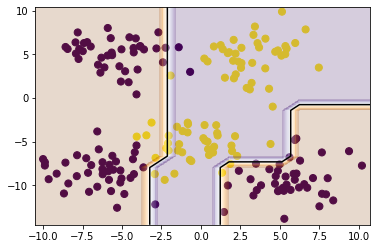

In [7]:
plt.figure()
_=plt.scatter(XX[:, 0], XX[:, 1], c=YY, s=50, cmap='viridis')
plt.contour(Xg, Yg, Yp, [0], colors='black')
_=plt.contourf(Xg, Yg, Yp, 20, cmap='PuOr', alpha=0.2)


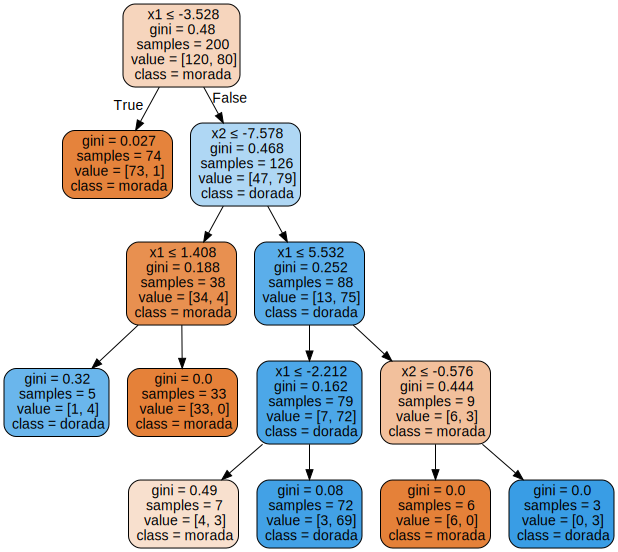

In [8]:
dot_Data = tree.export_graphviz(DT, 
                                out_file=None, 
                                feature_names = ['x1','x2'],
                               class_names=['morada','dorada'],
                                filled=True, 
                                rounded=True,  
                              special_characters=True)
graph = graphviz.Source(dot_Data)
graph

## Random Forests

---

Un **Random Forest** es un conjunto de árboles de decisión entrenados en modo **bagging**, es decir, cada árbol recibe un subconjunto aleatorio del conjunto de entrenamiento para conseguir algo de **diversidad**. Consigue poca correlación ente los árboles y mucha fuerza en cada uno de ellos. Para clasificar una observación de test, ésta se clasifica con todos los árboles del bosque y como clase final se devuelve la mayoritaria de entre las clasificaciones individuales.

El **bagging** permite diluir el efecto de las observaciones ruidosas y en general mejorar las prestaciones que podrían obtenerse entrenando un único árbol con todos los datos.

En scikit learn el módulo [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) implementa estos clasificadores.

In [9]:
from sklearn.ensemble import RandomForestClassifier

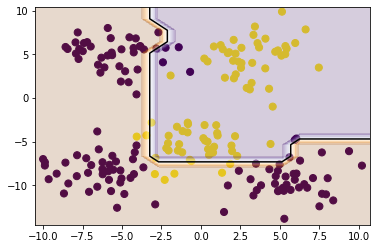

In [10]:
RF = RandomForestClassifier(max_leaf_nodes=4, n_estimators=10)
RF.fit(XX, YY)
Yp = RF.predict(x_test).reshape(Xshape)

plt.figure()
_=plt.scatter(XX[:, 0], XX[:, 1], c=YY, s=50, cmap='viridis')
plt.contour(Xg, Yg, Yp, [0], colors='black')
_=plt.contourf(Xg, Yg, Yp, 20, cmap='PuOr', alpha=0.2)


## Clasificador lineal de fisher

---

Este clasificador se conoce también como *Linear Discriminant Analysis*.

El clasificador lineal de Fisher combina **reducción de dimensión con clasificación**. Supongamos un **caso binario** con observaciones en $p$ dimensiones. El clasificador lineal de Fisher **busca la proyección a un espacio de dimensión reducida en la que se maximiza la separabilidad de las clases**. Podemos proyectar los datos sobre esta dirección y clasificarlos en este nuevo espacio.

En un problema **binario** es suficiente con un espacio reducido de una sola dimensión; en problemas **multiclase** el número de dimensiones que se pueden lograr es el mínimo entre el número de variables del problema y el número de clases menos 1.

La clase [`LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) implementa el clasificador lineal de Fisher en scikit learn.

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [12]:
clf = LinearDiscriminantAnalysis()
clf.fit(XX, YY)
Yp = clf.decision_function(x_test).reshape(Xshape)

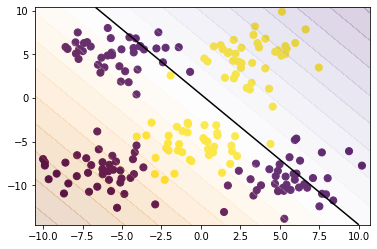

In [13]:
plt.figure()
_=plt.scatter(XX[:, 0], XX[:, 1], c=YY, s=50, cmap='viridis')
plt.contour(Xg, Yg, Yp, [0], colors='black')
_=plt.contourf(Xg, Yg, Yp, 20, cmap='PuOr', alpha=0.2)
